### Obtain spectra for the sources and add additional spec-zs from SIMBAD

In [96]:
%matplotlib inline
import sys, os, glob, warnings

warnings.filterwarnings('ignore', category=UserWarning, module='astroquery')

from astropy.io import fits, ascii

from astroquery.simbad import Simbad
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.wcs import WCS
from astropy.table import Column, Table

In [128]:
# A token is needed to access ADS and it locates at https://ui.adsabs.harvard.edu/user/settings/token

from astroquery import nasa_ads as na

na.ADS.TOKEN = 'Gh2X1K7QxOgpUq0kU3eG3QWNuer5wV6CaIjgkGdp'
na.ADS.NROWS = 20
na.ADS.SORT = 'bibcode desc'
na.ADS.ADS_FIELDS = ['author','title','pubdate', 'bibcode'] # 'bibcode' must be in the field
def get_ref(bibcode): 
    results = na.ADS.query_simple('bibcode:'+bibcode)
    author = results['author'][0][0].split(',')[0]
    year = results['pubdate'][0][0:4]
    return author + year

# try it
#get_ref('2013ApJ...767..118C')

In [3]:
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

### Read the DES AGN table:

https://ui.adsabs.harvard.edu/abs/2022MNRAS.516.2736B/abstract

In [200]:
data_agn = ascii.read('des_agn.txt', format='latex')

cat_agn = SkyCoord(data_agn['RA'], data_agn['dec'], unit='deg')
data_agn.rename_column(r'$g$', 'g')
data_agn.rename_column(r'$\sigma_{\rm{LB}}$', 'sigma_LB')
data_agn.rename_column(r'$\log\ \frac{M_{\ast}}{M_{\odot}}$', 'lgM')
data_agn.rename_column(r'$\Delta\chi_\nu^2$', 'dchi2')
data_agn.rename_column(r'$\log\ \frac{\tau_{\rm{\textsc{DRW},rest}}}{\rm{days}}$', 'lgtau')
# data_agn.rename_column(r'$z_{\rm{ph}}$', 'z_ph')
data_agn.rename_column(r'$z_{\rm{sp}}$', 'z_sp')
data_agn.rename_column(r'$z_{\rm{sp}}$ source', 'z_sp source')
data_agn.rename_column(r'$W1{-}W2$', 'W1-W2')
data_agn.rename_column(r'$\log \frac{F_{2-7 {\rm{\ keV}}}}{{\rm{erg\  s}}^{-1} {\rm{\ cm}}^{-2}}$', 'lgF')

# parse phot-z
data_agn.add_column(Column([float(i[1:5]) for i in data_agn[r'$z_{\rm{ph}}$']]), 
                    name='z_ph', index=data_agn.colnames.index(r'$z_{\rm{ph}}$') + 1)
data_agn.add_column(Column([i[8:12] for i in data_agn[r'$z_{\rm{ph}}$']]), 
                    name='z_ph_plus', index=data_agn.colnames.index('z_ph') + 1)
data_agn.add_column(Column([i[16:20] for i in data_agn[r'$z_{\rm{ph}}$']]), 
                    name='z_ph_minus', index=data_agn.colnames.index('z_ph_plus') + 1)
data_agn.remove_column(r'$z_{\rm{ph}}$')

data_agn

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,str4,str4,float64,str4,float64,float64,str5
J032833.79-271056.42,52.1408,-27.1823,23.7,14.2,13.3,$10.1 \pm 0.4$,0.1,$3.2 \pm 0.6$,1.02,0.03,0.04,nan,None,0.4,nan,SN-C3
J032951.20-271057.43,52.4633,-27.1826,23.4,15.3,12.7,$7.8 \pm 0.7$,0.1,$1.9 \pm 0.3$,0.24,0.04,0.02,nan,None,18.6,nan,SN-C3
J032944.64-271107.53,52.436,-27.1854,23.4,20.1,16.3,$9.4 \pm 0.5$,0.0,$2.4 \pm 0.8$,1.09,0.02,0.02,nan,None,0.9,nan,SN-C3
J032845.45-271117.18,52.1894,-27.1881,21.5,22.8,18.3,$9.7 \pm 0.0$,5.0,$1.7 \pm 0.2$,1.3,0.10,0.15,nan,None,1.1,nan,SN-C3
J032843.19-271117.75,52.1799,-27.1883,23.8,13.4,12.4,$8.8 \pm 0.5$,0.0,$2.7 \pm 0.8$,0.6,0.25,0.05,nan,None,nan,nan,SN-C3
J032850.22-271208.00,52.2093,-27.2022,19.2,26.1,20.3,$10.2 \pm 0.6$,0.0,$2.7 \pm 0.6$,0.9,0.40,0.30,nan,None,1.1,nan,SN-C3
J032913.11-271213.79,52.3046,-27.2038,22.9,21.6,17.2,$10.4 \pm 0.5$,0.3,$2.2 \pm 0.7$,1.25,0.15,0.10,nan,None,1.0,nan,SN-C3
J032847.11-271553.99,52.1963,-27.265,21.1,23.6,19.0,$7.3 \pm 0.1$,3.2,$3.6 \pm 0.4$,0.08,0.03,0.04,2.9784,2dF,18.1,nan,SN-C3
J033039.78-271740.97,52.6658,-27.2947,24.1,10.0,11.7,$9.6 \pm 0.5$,0.4,$1.9 \pm 0.4$,1.45,0.02,0.02,nan,None,nan,nan,SN-C3


### Match to SIMBAD using `astroquery`

Description for `add_votable_fields` refers to:  
https://github.com/astropy/astroquery/blob/main/astroquery/simbad/data/votable_fields_dict.json

In [152]:
M_star = data_agn[r'lgM']
M_star = np.array([d.split(' ')[0][1:] for d in M_star.data], dtype=float)

dChi2 = data_agn[r'dchi2']
dChi2 = np.array(dChi2, dtype=float)
mask_dwarf_agn = (M_star < 10) & (dChi2 > 2)

In [153]:
# mask_specz = np.isfinite(data_agn[r'z_sp'].data)

# print(len(data_agn[mask_specz]))

# Add the redshift information
customSimbad = Simbad()
customSimbad.add_votable_fields('rvz_qual','rvz_wavelength','z_value', 'rvz_bibcode', 'flux(i)')

result_table = customSimbad.query_region(cat_agn, radius=0.5*u.arcsec)

# Sources with RVZ_WAVELENGTH == 'O' or rvz_qual!='E' should have an optical spectrum

mask_spec_simbad = ((result_table['RVZ_WAVELENGTH']=='O') | (result_table['RVZ_WAVELENGTH']=='N'))  & (result_table['RVZ_QUAL']!='E') 

np.count_nonzero(mask_spec_simbad)

158

display simbad bibcodes

DES: https://academic.oup.com/mnras/article/509/3/3547/6412546

OzDES? 2015MNRAS.452.3047Y

In [155]:
simbad_bibcodes, cnt = np.unique(result_table[mask_spec_simbad]['RVZ_BIBCODE'], return_counts=True)

bibcodes_descs = {
    '2009ApJ...703.1778S': 'Spitzer/SWIRE', 
        # SWIRE/ XMM-Newton /ELAIS-S1 field, E2, http://irsa.ipac.caltech.edu/applications/Gator/
    '2009ApJ...707.1779E': 'BLAST', 
        # Great Observatories Origins Deep Survey-South, C3, seems not available
    '2010ApJS..191..124S': 'VIMOS & DEIMOS', 
        # Chandra Deep Field South (CDF-S), C3, https://member.ipmu.jp/john.silverman/CDFS_data.html & https://www.eso.org/~vmainier/cdfs_pub/
    '2011AJ....141...64X': 'Magellan LDSS-3 Galaxies', 
        # GOODS-N / CDF-S, C3, used existing Magellan spectra to study galaxies
    '2011MNRAS.414..500H': 'Spitzer compilation', 
        # Lockman / ELAIS S1 / N1 / N2 / Bootes, E2, https://www.denebola.org/atlas/
    '2012MNRAS.425.2116C': 'ACES', 
        # The Arizona CDFS Environment Survey using Magellan, C3, also mentioned the uncertainty of PRIMUS, seems not available
    '2012MNRAS.426.3334M': 'ATLAS', 
        # The Australia Telescope Large Area Survey (ATLAS) of CDFS, C3, this paper only published redshift
    '2013A&A...559A..14L': 'VVDS', 
        # VLT Deep Survey final data release, 0226 − 04 Deep = X3, ECDFS = C3,  http://cesam.lam.fr/vvds 
    '2013ApJ...772...48P': 'PEARS', 
        # Emission-line Galaxies from the Hubble Space Telescope Probing Evolution and Reionization Spectroscopically (PEARS) Grism Survey. II., GOODS-S = C3, used PEARS data by HST Advanced Camera for Surveys 
    '2013ApJS..208...24L': 'Spitzer AGN', 
        # Spitzer selected Optical & NIR selected AGN, E2, used many sources including observed themselves 
    '2014A&A...562A..23G': 'VIPERS PDR-1', 
        # The VIMOS Public Extragalactic Survey (VIPERS), X3, http://vipers.inaf.it/ 
    '2015ApJ...815..129S': 'FMOS AGN', 
        # X-ray selected broad-line AGNs, C3, captured spectra using FMOS which is not publicly available
    '2015ApJS..219...12A': 'SDSS-III DR12', 
        # SDSS-III DR12, available via astroquery?
    '2016MNRAS.457..110M': 'SDSS & WISE AGN', 
        # northern XMM-XXL field, X3, used existing SDSS & WISE spectra to identify X-ray-selected AGNs
    '2017AJ....153..107T': 'WISE & DES AGN', 
        # Stripe 82 & DES Supernova Fields, C3+X3+E2, used WISE & DES to select AGNs and had OzDES catalog
    '2018A&A...609A..84S': 'VIPERS PDR-2', 
        # updated version of 2014A&A...562A..23G
    '2018A&A...613A..51P': 'SDSS DR14Q', 
        # Sloan Digital Sky Survey Quasar Catalog: Fourteenth data release, https://live-sdss4org-dr14.pantheonsite.io/algorithms/qso_catalog , also astroquery?
    '2018MNRAS.474.3875B': 'GAMA DR3', 
        # Galaxy And Mass Assembly: the G02 field, Herschel-ATLAS target selection and data release 3, G02=X3, http://www.gama-survey.org/dr3/ 
    '2020ApJS..249....3A': 'SDSS DR16', 
        # First Release from the APOGEE-2 Southern Survey and Full Release of eBOSS Spectra, available via astroquery?
    '2020ApJS..250....8L': 'SDSS DR16Q_v4', 
        # SDSS-IV eBOSS, https://data.sdss.org/sas/dr16/eboss/qso/DR16Q , also astroquery?
    '2021ApJS..256....4C': 'MMT/Hectospec', 
        # XMM-LSS, ELAIS-N1, and DEEP2-3, XMM-LSS=X3, https://mips.as.arizona.edu/~cnaw/Faint_Low_z/ 
}

# visualization
table_bibcodes_descs = Table()
table_bibcodes_descs.add_column(simbad_bibcodes)
table_bibcodes_descs.add_column(Column(cnt, name='count'))
table_bibcodes_descs.add_column(Column([bibcodes_descs[i] for i in simbad_bibcodes], name='description'))
table_bibcodes_descs.sort('count', reverse=True)
table_bibcodes_descs

RVZ_BIBCODE,count,description
object,int64,str24
2016MNRAS.457..110M,50,SDSS & WISE AGN
2017AJ....153..107T,28,WISE & DES AGN
2012MNRAS.426.3334M,16,ATLAS
2010ApJS..191..124S,13,VIMOS & DEIMOS
2020ApJS..249....3A,12,SDSS DR16
2009ApJ...703.1778S,6,Spitzer/SWIRE
2015ApJS..219...12A,6,SDSS-III DR12
2018MNRAS.474.3875B,5,GAMA DR3
2014A&A...562A..23G,3,VIPERS PDR-1


### Add new spec-z into the table

In [201]:
data_agn_updated = data_agn.copy()

data_agn_updated['z_simb'] = -1.
data_agn_updated['r_z_simb'] = ' '*19

idx = result_table['SCRIPT_NUMBER_ID'].data.data - 1
idx_simbad_specz = idx[mask_spec_simbad]


for j,i in enumerate(idx_simbad_specz):
    # Update if no existing spec-z
    # if ~np.isfinite(data_agn_updated[r'z_sp'][i]):
    data_agn_updated[r'z_simb'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
    data_agn_updated[r'r_z_simb'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]

# mask_specz_updated = np.isfinite(data_agn_updated[r'z_sp'].data)
# print(len(data_agn_updated[mask_specz_updated]))
# mask_specz = np.isfinite(data_agn[r'z_sp'].data)
# print(len(data_agn[mask_specz]))

data_agn_updated.write('des_agn_updated.txt', format='ascii', overwrite=True)

## Visualize SIMBAD update

check selection bias

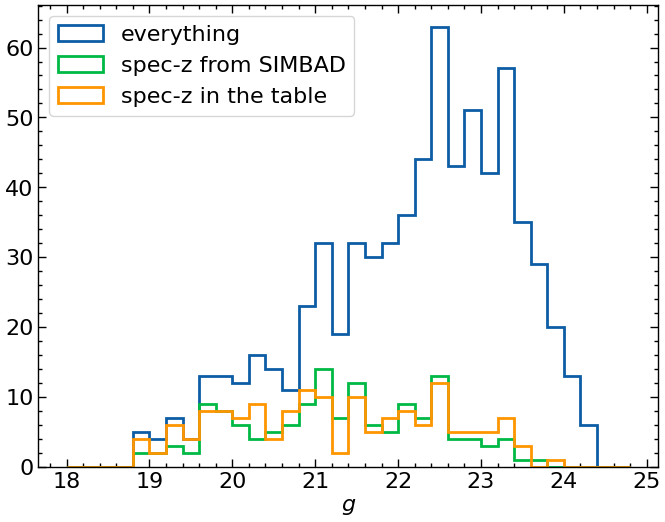

In [195]:
mask_specz_updated = np.isfinite(data_agn_updated['z_sp'].data)
mask_specz = data_agn_updated['z_simb']!=-1.

plt.hist(data_agn_updated['g'], 
         histtype='step', linewidth=2, bins=np.arange(18, 25, 0.2), label='everything')
plt.hist(data_agn_updated['g'][mask_specz_updated], 
         histtype='step', linewidth=2, bins=np.arange(18, 25, 0.2), label='spec-z from SIMBAD')
plt.hist(data_agn['g'][mask_specz], histtype='step', 
         linewidth=2, bins=np.arange(18, 25, 0.2), label='spec-z in the table')
plt.xlabel('$g$')
plt.legend(frameon=True, loc='upper left')

plot in skymap

/tmp/ipykernel_933/2091786815.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


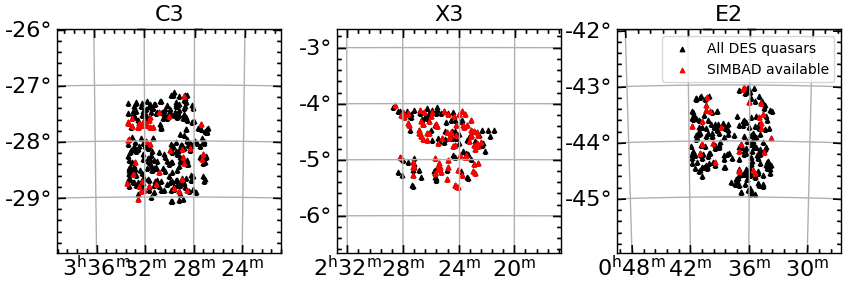

In [121]:
fig = plt.figure(figsize=[8, 8], dpi=100)

text_coords = ['52d30m -28d', '36d10m -4d40m', '9d30m -44d']
fields = ['C3', 'X3', 'E2']

axlist = []
for i, (text_coord, field) in enumerate(zip(text_coords, fields)): 
    center_coord = SkyCoord(text_coord)
    width = 1*u.deg
    wcs = WCS(naxis=2)
    wcs.wcs.crpix = [1, 1]
    wcs.wcs.cdelt = [-width.to_value(u.deg), width.to_value(u.deg)]
    wcs.wcs.crval = [center_coord.ra.deg, center_coord.dec.deg]
    wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    ax1 = plt.axes([0.35*i, 0, 0.28, 1], projection=wcs)
    ax1.set_aspect('equal')
    ax1.scatter(cat_agn.ra, cat_agn.dec, 
                transform=ax1.get_transform('world'), s=10, marker='^', color='k', alpha=1, 
                label='All DES quasars')
    mask_simbad_available = data_agn_updated['z_simb']!=-1.
    ax1.scatter(cat_agn.ra[mask_simbad_available], cat_agn.dec[mask_simbad_available], 
                transform=ax1.get_transform('world'), s=10, marker='^', color='r', alpha=1, 
                label='SIMBAD available')
    ax1.grid()
    ax1.set_title(field)
    ax1.coords['ra'].set_auto_axislabel(False)
    ax1.coords['dec'].set_auto_axislabel(False)
    ax1.set_xlim(-2, 2) # using deg as unit as defined in wcs.wcs.cdelt
    ax1.set_ylim(-2, 2)
    axlist.append(ax1)

plt.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()
# fig.savefig('cosmos.eps', format='eps')

export source profile

In [ ]:
# TODO

profile = table.Table(data=np.array([
        ['0', sum(data_agn_updated['r_z']==0), '-', 'SIMBAD', '-'],
        ['1', sum(data_agn_updated['r_z']==1), '-', 'HSC DR3', '-'],
    ]), 
    names=['Colin/SIMBAD', 'count', 'bibcode', 'description', 'refcode'], 
    dtype=('U6',  'i4',    'U19',     'U26',         'U21')
)

# left alignment
for col in profile.columns: 
    profile[col].format='<'

# add Colin
for i, bibcode in enumerate(simbad_bibcodes): 
    profile.add_row(['z0_%02d'%(i+1), np.count_nonzero(data_agn_updated['r_z0']==i+1), bibcode, '', get_ref(bibcode)])


# add Simbad 

for (bibcode, description, rz_code) in hsc_bibcodes.values(): 
    profile.add_row(['z1_%02d'%(rz_code), np.count_nonzero(data_agn_updated['r_z1']==rz_code), 
                    bibcode, description, get_ref(bibcode)])

#TODO: Should probably look the individual sources that are matched in e.g. DR2 but not DR3?

profile.pprint_all()

visualize our update

In [213]:
data_agn_updated['z_before'] = data_agn_updated['z_ph']
data_agn_updated['z_before'][data_agn_updated['z_sp']>0] = data_agn_updated['z_sp'][data_agn_updated['z_sp']>0]

data_agn_updated['z_after'] = data_agn_updated['z_before']
data_agn_updated['z_after'][data_agn_updated['z_simb']>0] = data_agn_updated['z_simb'][data_agn_updated['z_simb']>0]

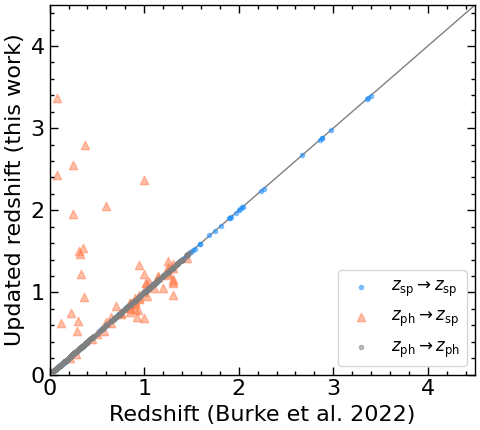

In [223]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))

mask_sp_before = data_agn_updated['z_sp']>0
mask_sp_after = (data_agn_updated['z_sp']>0) | (data_agn_updated['z_simb']>0)

mask_sp2sp = mask_sp_before & mask_sp_after
ax.scatter(data_agn_updated['z_before'][mask_sp2sp], data_agn_updated['z_after'][mask_sp2sp], 
           marker='.', color='dodgerblue', label=r'$z_{\rm sp} \rightarrow z_{\rm sp}$', alpha=0.5)

mask_ph2sp = (~mask_sp_before) & mask_sp_after
ax.scatter(data_agn_updated['z_before'][mask_ph2sp], data_agn_updated['z_after'][mask_ph2sp], 
           marker='^', color='coral', label=r'$z_{\rm ph} \rightarrow z_{\rm sp}$', alpha=0.5)

mask_ph2ph = (~mask_sp_before) & (~mask_sp_after)
ax.scatter(data_agn_updated['z_before'][mask_ph2ph], data_agn_updated['z_after'][mask_ph2ph], 
           marker='.', color='gray', label=r'$z_{\rm ph} \rightarrow z_{\rm ph}$', alpha=0.5)

ax.plot([0, 4.5], [0, 4.5], lw=1, zorder=-2, color='gray')
ax.set_xlabel('Redshift (Burke et al. 2022)')
ax.set_ylabel('Updated redshift (this work)')
ax.legend(frameon=True, loc='lower right', fontsize=12)
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)
fig.savefig('specz.pdf', dpi=300)

fig.tight_layout()

check inconsistency

In [ ]:
# TODO

# No Z_sp-Z_sp or updated database, so seems like no inconsistency to check in this (redshift) stage. 

In [214]:
data_agn_updated

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_before,z_after
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,str4,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64
J032833.79-271056.42,52.1408,-27.1823,23.7,14.2,13.3,$10.1 \pm 0.4$,0.1,$3.2 \pm 0.6$,1.02,0.03,0.04,nan,None,0.4,nan,SN-C3,-1.0,,1.02,1.02
J032951.20-271057.43,52.4633,-27.1826,23.4,15.3,12.7,$7.8 \pm 0.7$,0.1,$1.9 \pm 0.3$,0.24,0.04,0.02,nan,None,18.6,nan,SN-C3,-1.0,,0.24,0.24
J032944.64-271107.53,52.436,-27.1854,23.4,20.1,16.3,$9.4 \pm 0.5$,0.0,$2.4 \pm 0.8$,1.09,0.02,0.02,nan,None,0.9,nan,SN-C3,-1.0,,1.09,1.09
J032845.45-271117.18,52.1894,-27.1881,21.5,22.8,18.3,$9.7 \pm 0.0$,5.0,$1.7 \pm 0.2$,1.3,0.10,0.15,nan,None,1.1,nan,SN-C3,-1.0,,1.3,1.3
J032843.19-271117.75,52.1799,-27.1883,23.8,13.4,12.4,$8.8 \pm 0.5$,0.0,$2.7 \pm 0.8$,0.6,0.25,0.05,nan,None,nan,nan,SN-C3,-1.0,,0.6,0.6
J032850.22-271208.00,52.2093,-27.2022,19.2,26.1,20.3,$10.2 \pm 0.6$,0.0,$2.7 \pm 0.6$,0.9,0.40,0.30,nan,None,1.1,nan,SN-C3,0.803,2017AJ....153..107T,0.9,0.803
J032913.11-271213.79,52.3046,-27.2038,22.9,21.6,17.2,$10.4 \pm 0.5$,0.3,$2.2 \pm 0.7$,1.25,0.15,0.10,nan,None,1.0,nan,SN-C3,-1.0,,1.25,1.25
J032847.11-271553.99,52.1963,-27.265,21.1,23.6,19.0,$7.3 \pm 0.1$,3.2,$3.6 \pm 0.4$,0.08,0.03,0.04,2.9784,2dF,18.1,nan,SN-C3,-1.0,,2.9784,2.9784
J033039.78-271740.97,52.6658,-27.2947,24.1,10.0,11.7,$9.6 \pm 0.5$,0.4,$1.9 \pm 0.4$,1.45,0.02,0.02,nan,None,nan,nan,SN-C3,-1.0,,1.45,1.45
